(System:system)=
# System Dynamics
So, now that we have been introduced to the idea of filtering and how to recursively compute estimates as the measurements become available. What is the next step?

Imagine yourself being onboard a large container ship at constant velocity, and your task is to report the position of the ship every second. Wouldn't you agree that there is quite a lot of information in just knowing that you are onboard such a large, heavy ship?

![ship](fig/ship.jpg)

The large mass and inertia of this vessel means that the positions the next seconds, or even minutes, are highly predictable. Just by knowing the heading and velocity of this vessel at some point in time, you can easily predict the position with high accuracy for some time ahead even without making any measurements at all! So, to exploit this valuable information we need to introduce a model for the physical behaviour of our platform. This is what is called the *dynamic model*.

The level of detail needed for the dynamic model depends highly on the type of measurements that are available from our sensors, together with their sampling rate and precision. Let's say we have frequent measurements available from sensors on a platform in a highly deterministic environment, e.g. a trolley on rails. In this case we can choose a rather simple dynamic model. However, if we have a platform with in a highly unpredictable environment, e.g. a drone, then we might need to introduce a more complex dynamic model containing elements such as, e.g. wind speed, wind direction and turbulence.

```{figure} fig/simple.jpg
---
height: 200px
name: Simple
---
Simple
```

```{figure} fig/complex.jpg
---
height: 200px
name: Complex
---
Complex
```

First let's start with the simple example of a trolley on rails and start developing the dynamic model from there.

One good reference to have at hand at this moment is An Introduction to the Kalman Filter {cite}`welch1995`

## Differential Equations
The starting point is a first order, linear differential equation. It will look something like this.

$$
\dot{x}=Fx
$$

where the vector $x$ is the *state vector* containing the parameters to be estimated such as, e.g. position and velocity. The vector $\dot{x}$ is the time derivative of the state vector. The matrix $F$ is called the *dynamics matrix* and it basically connects the state vector $x$ with it's own time derivative. This accounts for the *deterministic* part of the dynamic model, i.e. the physical laws that apply to the platform.

```{figure} fig/trolley.png
:name: trolley

Trolley on rails
```

So, if our trolley rolled perfectly on the rails without any friction or vibrations what so ever, we could use this equation to compute the state vector for eternity as this equation would perfectly describe the platform behaviour. However, in the real world there will always be friction, vibrations and air resistance making this equation just approximately true. We could of course choose to model both the friction, vibrations and air resistance to the best of our extent, but still there will inevitably be some degree of approximations involved in our models of the real world.

Instead of modelling all these phenomena, we are compensating for these *unmodelled effects* by adding a second term to our differential equation. This accounts for the *stochastic* part of the model, i.e. all the remaining effects that we are unable to model in a deterministic manner, and we express this sum as a continuous differential equation.

$$
\dot{x}=Fx + Gu
$$

where the matrix $G$ is a vector/matrix of white noise coefficients. These coefficients scale the unity white noise $u$ into a proper size that act as what is called the *driving noise* of our system model.

### Transition Matrix
The next thing to do now is to solve this differential equation and derive a set of expressions to propagate the state vector $x$ into the future in a discrete manner. In other words, we need an equation to make predictions of the system state as the trolley rolls along the rails at discrete points in time. So, what we are looking for is an equations on this form:

$$
x_k = \phi x_{k-1}
$$

where the $x_k$ is the predicted state vector at time $k$. The matrix $\phi$ is called the *transition matrix*.

Solving differential equations can be somewhat tricky, and in practice these solutions are done pure numerically. We will get back to standarized ways of solving these differantial equations later. However, for completeness and our intuition we will now derive a straight forward ordinary differential equation (ODE)  solution of the deterministic part of the dynamic model with the condition that the dynamic matrix $F$ is constant.

```{note}
The Python **sympy** package is a very powerful tool to do symbolic calculations in order to derive the generic structure of solutions to equations
```

In [1]:
from sympy import symbols, diff, Function, Eq, dsolve

F, t = symbols('F t')

x = Function('x')(t) 

dxdt = diff(x, t)
expr = Eq(dxdt, F*x)
display(expr)

Eq(Derivative(x(t), t), F*x(t))

In [2]:
sol = dsolve(expr)
display(sol)

Eq(x(t), C1*exp(F*t))

This lead to this fairly simple solution for the unknown transition matrix $\phi$.

$$
\phi=e^{F\Delta t}
$$

If we further develop this equation into a Taylor series expansion, we get the following equation for the transition matrix $\phi$.

$$
\phi=I + F\Delta t + \frac{(F\Delta t)^2}{2!} + \dots
$$

Note that the transition matrix is also dependent on the time step $k$ and should technically be written as $\phi_{k-1}$. However, in these very first simple examples it will remain a constant so we therefore omit the subscript for clarity.

Now that we have everything we need, let's test the dynamic part of the dynamic model with our trolley on rails through a simple numerical example.

### Example 2.1
Assume we want to estimate the position and velocity of the trolley, and that we give the trolley a slight push from the starting position $x=0$ for it to start rolling along the rails with a velocity of $\dot{x}=1 m/s$. The inital values are given as:

$$
x_0=
\begin{bmatrix}
  0\\
  1\\
\end{bmatrix}
$$
  
A reasonable deterministic system model $\dot{x}=Fx$ could then look something like this:

$$
\begin{bmatrix}
  \dot{x}\\
  \ddot{x}\\ 
\end{bmatrix}
=
\begin{bmatrix}
  0 &1\\
  0 &0\\
\end{bmatrix}
\begin{bmatrix}
  x\\
  \dot{x}\\
\end{bmatrix}
$$

Given the dynamics matrix $F$, we can compute the transition matrix $\phi$ as follows. Note that since $F^2 = 0$ we can safely cut the series after the linear part without loss of information.

$$
\begin{align}
  \phi=&
  \begin{bmatrix}
    1 &0\\
    0 &1\\
  \end{bmatrix}
  +
  \begin{bmatrix}
    0 &1\\
    0 &0\\
  \end{bmatrix} \Delta t\\
  =&
  \begin{bmatrix}
    1 &\Delta t\\
    0 &1\\
  \end{bmatrix}\\
\end{align}
$$

Performing the time update step, we can compute the state vector as follows:

$$
x_1 = \phi x_0
$$

So, what is the position and velocity of the trolley after $\Delta t=10s$?

$$
\begin{bmatrix}
  x\\
  \dot{x}\\
\end{bmatrix}
=
\begin{bmatrix}
  1 &10\\
  0 &1\\
\end{bmatrix}
\begin{bmatrix}
  0\\
  1\\
\end{bmatrix}
$$

In [3]:
from numpy import array, eye

# System values
dt = 10   # interval [seconds]

# Inital state vector
x0 = array([[0],    # position [meter]
            [1]])   # velocity [meter/second]

# Dynamic matrix
F = array([[0, 1],
           [0, 0]])

# Transition matrix
phi = eye(2) + F*dt

# Time update
x1 = phi@x0

print(f"Position: {x1[0, 0]:5.1f} m")
print(f"Velocity: {x1[1, 0]:5.1f} m/s")

Position:  10.0 m
Velocity:   1.0 m/s


According to the deterministic part of the dynamic model, then after 10 seconds with a constant velocity of 1 m/s, the trolley has moved 10 meter down the rails. This seems like a perfectly reasonable result under these ideal conditions, i.e. no friction, vibration or air resistance.

## Laplace Transform
Since the dynamic model basically is just a set of ODEs, the generic solution for the transition matrix can always be solved in the complex s-domain through the *Laplace transform*. The generic solution for the transition matrix is stated below.

$$
\phi = \mathscr{L}^{-1}\{(sI-F)^{-1}\}_{t=\Delta t}
$$

Based on our the dynamic matrix $F$ in the previous example the solution becomes as follows.

$$
\begin{align}
   \phi =& \mathscr{L}^{-1}\{
   \begin{bmatrix}
      s &0\\
      0 &s\\
   \end{bmatrix}
   -
   \begin{bmatrix}
     0 &1\\
     0 &0\\
   \end{bmatrix}^{-1} \}_{t=\Delta t}\\
   =& \mathscr{L}^{-1}\{
   \begin{bmatrix}
      s &-1\\
      0 &s\\
   \end{bmatrix}^{-1} \}_{t=\Delta t}\\
   =& \mathscr{L}^{-1}\{
   \begin{bmatrix}
      \frac{1}{s} &\frac{1}{s^2}\\
      0 &\frac{1}{s}\\
   \end{bmatrix}\}_{t=\Delta t}\\
   \vdots\\
   \phi =&
   \begin{bmatrix}
      1 &\Delta t\\
      0 &1\\
   \end{bmatrix}\\
\end{align}
$$

As expected this is exactly the same result as with the previous Taylor series expansion. Note the Taylor series expansion is in practice only useful with very simple dynamic systems in practice as it becomes untracktable when many parts of the series need to ba added in order for a proper approximation of the underlying dynamics.

Before we continue, let's first use sympy to generate a short list of some common Laplace transform pairs slightly beyond what shows up in this simple example.

In [4]:
from sympy import symbols, init_printing, laplace_transform, exp, sin, cos

init_printing()

a, s, omega = symbols('a s omega', real=True)

ft = [1, t, exp(-a*t), t*exp(-a*t), t**2*exp(-a*t), sin(omega*t), cos(omega*t), 1 - exp(-a*t)]
display(ft)

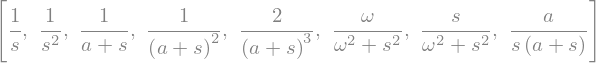

In [5]:
Fs = [laplace_transform(f, t, s, noconds=True) for f in ft]
display(Fs)

```{note}
This example demonstrates the power of Python when it comes to efficient code for automated processing of elements in a list.
```

## Error Analysis
In addition to the estimate of the state vector, we also need to derive the corresponding covariance matrix to account for the stochastic part of the dynamics model. Propagating the deterministic part of the covariance matrix is straight forward from the law of error propagation. For completeness we write both the equations for the deterministic part here as follows.

$$
\begin{align}
  x_k =& \phi x_{k-1}\\
  P_k =& \phi P_{k-1} \phi^T\\
\end{align}
$$

Note that these two equations only propagate the determinstic part of the dynamic model, eventhough the covariance matrix $P$ is involved - we have not yet introduced the stochastic part of the model.

In order to do that we have to introduce some uncertainty into our discrete equation to account for all the unmodelled effects. Thus, we expand the original equation as follows with the noise vector $w$.

$$
x_k = \phi x_{k-1} + w_{k-1}
$$

The noise vector $w$ is called *process noise* and it is basically the accumulated noise between each point in time. The covariance matrix $Q$ of this noise vector is called the *process noise covariance* and it can be computed as follows.

$$
\begin{align}
  Q_k =& E[w_k w_k^T]\\
    =& E[\int_{t_k}^{t_{k+1}} \phi(t_{k+1}, \epsilon) G(\epsilon) u(\epsilon) d\epsilon \cdot \int_{t_k}^{t_{k+1}} (\phi(t_{k+1}, \eta) G(\eta) u(\eta))^T d\eta]\\
    =& E[\int_{t_k}^{t_{k+1}} \int_{t_k}^{t_{k+1}} \phi(t_{k+1}, \epsilon) G(\epsilon) u(\epsilon) u(\eta)^T G^T(\eta) \phi^T(t_{k+1}\eta) d\epsilon d\eta]\\
    =& \int_{t_k}^{t_{k+1}} \int_{t_k}^{t_{k+1}} \phi(t_{k+1}, \epsilon) G(\epsilon) \: E[u(\eta) u(\epsilon)^T] \: G^T(\eta) \phi^T(t_{k+1}\eta) d\epsilon d\eta\\
    =& \int_{t_k}^{t_{k+1}} \int_{t_k}^{t_{k+1}} \phi(t_{k+1}, \epsilon) G(\epsilon) \: \delta(\eta - \epsilon) \: G^T(\eta) \phi^T(t_{k+1}\eta) d\epsilon d\eta\\
    \vdots\\
  Q_k =& \int_{t_k}^{t_{k+1}} \phi(t_{k+1}, \epsilon) G(\epsilon) G^T(\epsilon) \phi^T(t_{k+1}, \epsilon) d\epsilon\\
\end{align}
$$

So, now we have derived the complete discrete dynamic model as two discrete equations. This set of equations are called *time update* since it propagates the state vector and the corresponding covariance matrix into the future.

$$
\begin{align}
  x_{k} =& \phi x_{k-1}\\
  P_{k} =& \phi P_{k-1} \phi^T + Q_{k-1}\\
\end{align}
$$

(Sysdyn:example22)=
### Example 2.2
Now let's test the complete dynamic model with our trolley on rails with another simple numerical example.

Assume that we want to estimate the position and velocity of the trolley, and that we give the trolley a slight push for it to start rolling along the rails. This time we also have to specify the uncertainty in the initial state vector throught he initial covariance matrix. Thus the inital values are given as:

$$
x_0=
\begin{bmatrix}
  0\\
  1\\
\end{bmatrix} \quad
P_0=
\begin{bmatrix}
  1 &0\\
  0 &0.25\\
\end{bmatrix}
$$

A reasonable system model could then look something like this:

$$
\begin{bmatrix}
  \dot{x}\\
  \ddot{x}\\ 
\end{bmatrix}
=
\begin{bmatrix}
  0 &1\\
  0 &0\\
\end{bmatrix}
\begin{bmatrix}
  x\\
  \dot{x}\\
\end{bmatrix}
+
\begin{bmatrix}
  0\\
  \sqrt{q_v}\\
\end{bmatrix}
u
$$

Note that the dynamic matrix $F$ is the same, thus there is no change to the transition matrix $\phi$. However, now we have also introduced process noise to the velocity through the term $q_v$. This value can be interpreted as "variance per time unit" during each time interval and is set to 0.01 (m/s)^2/s.

Now we have everything we need to compute the noise covariance matrix.

$$
\begin{align}
  Q =& \int_{t_k}^{t_{k+1}} \phi(t_{k+1}, \epsilon) G(\epsilon) G^T(\epsilon) \phi^T(t_{k+1}, \epsilon) d \epsilon \\
    =& \int_{t_k}^{t_{k+1}}
    \begin{bmatrix}
      1 &\epsilon\\
      0 &1\\
    \end{bmatrix}
    \begin{bmatrix}
      0\\
      \sqrt{q_v}\\
    \end{bmatrix}
    \begin{bmatrix}
      0 &\sqrt{q_v}\\
    \end{bmatrix}
    \begin{bmatrix}
      1 &0\\
      \epsilon &1\\
    \end{bmatrix} d \epsilon\\
    =& \int_{t_k}^{t_{k+1}}
    \begin{bmatrix}
      \frac{1}{2} q_v \epsilon^2 &q_v \epsilon\\
      q_v \epsilon &q_v\\
    \end{bmatrix} d \epsilon\\
    \vdots\\
  Q =& 
    \begin{bmatrix}
      \frac{1}{3} q_v \Delta t^3 &\frac{1}{2} q_v \Delta t^2\\
      \frac{1}{2} q_v \Delta t^2 &q_v \Delta t\\
    \end{bmatrix}
\end{align}
$$

To verify, we can also directly compute the symbolic solution in Python which may look something like this.

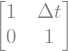

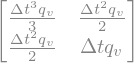

In [6]:
# Compute transistion matrix and process noise matrix

# Import
from sympy import Symbol, Matrix, sqrt, eye, integrate

# Define symbols
dt = Symbol('\Delta t')
qv = Symbol('q_v')

# Dynamic matrix
F = Matrix([[0, 1],
            [0, 0]])

# Transition matrix
phi = eye(2) + F*dt
display(phi)

# White noise coefficients
G = Matrix([[0],
            [sqrt(qv)]])

# Process noise matrix
Q = integrate(phi@G@G.T@phi.T,  (dt, 0, dt))
display(Q)

Then performing the time update step, we compute the state vector and the corresponding covariance matrix as follows:

$$
\begin{align}
  x_1 =& \phi x_0\\
  P_1 =& \phi P_0 \phi^T + Q\\
\end{align}
$$

So, what is the position, velocity and the corresponding covariance matrix of the trolley after 10 seconds?

In [7]:
from numpy import array, eye, sqrt

# System values
dt = 10        # interval [seconds]
qv = 0.1**2    # process noise [(meter/second)^2/second]

# Inital state vector
x0 = array([[0],    # position [meter]
            [1]])   # velocity [meter/second]

# Initial state covariance matrix
P0 = array([[1, 0],           # [meter^2]
            [0, 0.25]])       # [(meter/second)^2]

# Dynamic matrix
F = array([[0, 1],
           [0, 0]])

# Transition matrix
phi = eye(2) + F*dt

# Process noise
Q = array([[1/3*qv*dt**3, 1/2*qv*dt**2],
           [1/2*qv*dt**2, qv*dt]])

# Time update
x1 = phi@x0
P1 = phi@P0@phi.T + Q

print(f"Position: {x1[0, 0]:5.1f} m,   std: {sqrt(P1[0, 0]):5.2f} m")
print(f"Velocity: {x1[1, 0]:5.1f} m/s, std: {sqrt(P1[1, 1]):5.2f} m/s")

Position:  10.0 m,   std:  5.42 m
Velocity:   1.0 m/s, std:  0.59 m/s


## Adding More Complexity
But what happens if our model is slightly more complex than our trolley on rails? Let's try with adding some more components to increase the complexity of our model.

Assume our trolley on rails is attached to a wall with a spring and a damper.

```{figure} fig/trolley_complex.png
:name: trolley_complex

Complex trolley on rails
```

This is clearly a more complex dynamic system that requires a more detalied description. This description goes into the the dynamics matrix $F$. Let's start with determining the forces that act upon the trolley. There are only two forces involved: one comes from the spring where the force is proportional to the position, and one comes from the damper where the force is proportional to the velocity.

From Newtons second law we have that:

$$
\Sigma F = ma
$$

So, if we add together all the forces we obtain the following differential equation:

$$
\begin{align}
  m\ddot{x} + c\dot{x} + kx =& 0\\
  \ddot{x} =& -\frac{c}{m}\dot{x} - \frac{k}{m}x\\
\end{align}
$$

In matrix form the system model will now look something like this:

$$
\begin{bmatrix}
  \dot{x}\\
  \ddot{x}\\
\end{bmatrix}
=
\begin{bmatrix}
  0 &1\\
  -k/m &-c/m\\
\end{bmatrix}
\begin{bmatrix}
  x\\
  \dot{x}\\
\end{bmatrix}
$$

In order to have an idea of the generic structure of the solution of this ODE, we can use sympy's *dsolve* function. Than we can write as follows.

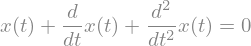

In [8]:
from sympy import symbols, diff, Eq, dsolve

x = symbols('x', cls=Function)

dxdt = x(t).diff(t, 1)
dxdt2 = x(t).diff(t, 2)

expr = Eq(dxdt2 + dxdt + x(t), 0)
expr

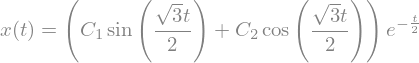

In [9]:
sol = dsolve(expr)
sol

As seen above the generic solution will be a damped sine/cosine wave corresponding to the trolley bouncing back and fourth until the damper has slowed down the movement completely. So, now lets see what what the corresponding Kalman filter solution will look like as we simulate the situation for a period of 100 seconds.

### Example 2.3
Note that eventhough the dynamic matrix is still a constant, it is not convenient to derive the transition matrix following our previous approach as this would require to take a larger part of the series expansion into account. Since we have not yet introduced more efficient methods for numerical evaluation of the transition matrix, we will for simplicity just make a coarse approximation using only the linear part of the series expansion.

$$
\phi \approx I + F\Delta t
$$

Following this approach the approximate transition matrix will look like this.

$$
\phi \approx
\begin{bmatrix}
  1 &0\\
  0 &1\\
\end{bmatrix}
+
\begin{bmatrix}
  0 &1\\
  -k/m &-c/m\\
\end{bmatrix} \Delta t
$$

So, now let's also test this more complex system dynamics with a simple numerical example.

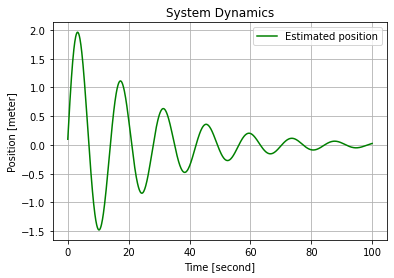

In [11]:
from numpy import array, eye, arange
import matplotlib.pyplot as plt

# System values
dt = 0.1         # interval [seconds]
samples = 1000   # number of samples
m = 0.5          # mass [kg]
k = 0.1          # spring constant
c = 0.05         # damper constant

# Inital state vector
x = array([[0],    # position [meter]
           [1]])   # velocity [meter/second]

# Dynamic matrix
F = array([[0, 1],
           [-k/m, -c/m]])

# Transition matrix (approximation)
phi = eye(2) + F*dt

# Initialize plot vectors
x_all = []

# Main loop
for k in range(0, samples + 1):
    
    # Time update
    x = phi@x
    
    # Accumulate plot vectors
    x_all.append(x)

# Extract plot vectors
pos_est = [x[0] for x in x_all]

# Time
time = arange(0, samples + 1)*dt

# Plot results
plt.title("System Dynamics")
plt.plot(time, pos_est, 'g', label='Estimated position')
plt.xlabel("Time [second]")
plt.ylabel("Position [meter]")
plt.legend(loc='upper right')
plt.grid();plt.show()

As expected the behaviour of the trolley corresponds with what is known as a *damped harmonic oscillation*. The trolley is given a small initial velocity and it keeps bouncing back and forth until the velocity has converged to zero. Eventhough we can see the general shape of the oscillation here, beware that the transition matrix is just an approximation and for a a more precise solution we will need more efficient methods to compute a numeric solution. We will get back to more efficient numerical solutions later.

## Summary
In this chapter we have introduced the basic ideas of how to model the system dynamics as a set of ordinary differential equations. The solution to these equations provides the deterministic part of the platform dynamics as a function of time. This can intuitively be looked upon as the *laws of nature* in matrix form. Thus an increased complexity of the dynamic model leads to a more complex dynamic matrix $F$ that again are responsible for all the connections between the elements in the state vector

However, even if very sophisticated, these models cannot capture all effect that we experience in the real world so in practice we will always need to add some process noise to our equations to account for these unmodelled effects. The amount of noise will be highly dependent on the application at hand, thus tuning it properly will in practice require some experience.

So, now we have derived the main equations for the system dynamics which is called *time update* in the Kalman filter vocabulary. The two equations read as follows.

$$
\begin{align}
  x_k =& \phi x_{k-1}\\
  P_k =& \phi P_{k-1} \phi^T + Q\\
\end{align}
$$

However if we look at the propagation of the covariance matrix $P$ ahead in time, it seems just to grow without limits as the process noise matrix $Q$ is added in every time update step. Or to state it differently - as times go by the predictions from our dynamic model becomes less and less precise. Unless we have made a perfect model of the real world, every update steps will introduce more and more uncertainty into our estimate as time go by. But how do we deal with this?

I thinkt it's about time to have a look at how to introduce some measurements...